# Using samplers

Once a multimodal variational encoder is trained, new samples can be generated by sampling a latent code from the prior and then decoding it using the trained decoder distributions. 
However, joint generation of new samples can be improved by *a posteriori* fitting a distribution on the training latent codes and using that distribution to sample new latent variables closer to the ones seen in training. 
That strategy can be used to generate more realistic images. 

In MultiVae, three samplers are available in `multivae.samplers`
- A Gaussian Mixture Model (GMM)
- A Masked Autoregressive Flow (MAF) distribution.
- A Inverse Autoregressive Flow (IAF) distribution.

All implement parametric distributions that can be fit on the training latent codes of a trained model. 

In this notebook we provide examples on how they can be used. 
We load a trained model from HuggingFace Hub as an example model. 

If you don't have HuggingFace installed, run:
````bash
$ pip install huggingface_hub
````
to install it.


In [1]:
from multivae.models import AutoModel

model = AutoModel.load_from_hf_hub(
    "asenella/reproducing_mvtcae_seed_0", allow_pickle=True
)

/home/asenella/miniconda3/envs/multivaenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No environment.json file found. If you have an error while pickling architectures, check that the python version used for saving is the same than the one you use for reloading the model.
Successfully downloaded encoders architecture.
Successfully downloaded decoders architecture.
Successfully downloaded MVTCAE model!


# Gaussian Mixture Sampler


## Fit a GMM sampler
First we will fit a Gaussian Mixture Model on the latent space of this multimodal VAE. 
We define the number of mixture components to be equal to 10 in this example. 

In [2]:
from multivae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

config = GaussianMixtureSamplerConfig(
    n_components=10  # number of components to use in the mixture
)

gmm_sampler = GaussianMixtureSampler(model=model, sampler_config=config)

We load the training multimodal dataset that we will use to compute latent codes and fit the GMM model. 

In [3]:
# load training set
from multivae.data.datasets.mmnist import MMNISTDataset

DATA_PATH = "/home/asenella/data"  # Set your datapath
dataset = MMNISTDataset(data_path=DATA_PATH, split="train", download=True)

In [4]:
# Fit the sampler (this might take a while)
gmm_sampler.fit(dataset)

## Generate new samples
You can now use this GMM model to sample relevant latent codes in the latent space of the model.

In [5]:
# you can now use that sampler to sample new latent codes, and new images

samples = gmm_sampler.sample(n_samples=3)

print("Latent samples :", samples.z)

Latent samples : tensor([[ 1.6534,  0.3237,  0.0071,  ...,  0.9887,  0.3207,  0.3077],
        [ 0.4496, -1.2599, -0.5022,  ..., -0.4616, -0.6884, -1.3300],
        [-2.2556,  0.1803, -1.3223,  ...,  0.0522,  0.2574,  0.3064]],
       device='cuda:0')


We can decode these samples to produces new images in each modality.

In [6]:
generations = model.decode(samples)

print('Shape of generations in modality "m1" : ', generations.m1.shape)

Shape of generations in modality "m1" :  torch.Size([3, 3, 28, 28])


We can plot the generations using matplotlib as shown below. 

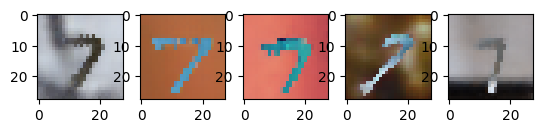

In [9]:
# We can plot the first multimodal sample using matplotlib

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 5)
ax[0].imshow(generations.m0[0].cpu().numpy().transpose(1, 2, 0))
ax[1].imshow(generations.m1[0].cpu().numpy().transpose(1, 2, 0))
ax[2].imshow(generations.m2[0].cpu().numpy().transpose(1, 2, 0))
ax[3].imshow(generations.m3[0].cpu().numpy().transpose(1, 2, 0))
ax[4].imshow(generations.m4[0].cpu().numpy().transpose(1, 2, 0))

 ## Use the Visualization Module with the sampler

 If you want to plot and save a lot of generations easily, you should know that the Visualization Module can be used with your trained sampler. Below we show how to use the Visualization class with and without the sampler. 

Sampling from the prior:


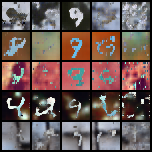

Sampling from the GMM model:


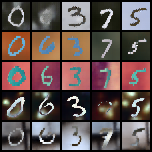

In [ ]:
# For instance to visualize joint generation with the Visualization module

from multivae.metrics import Visualization

# Use the Visualization module WITHOUT the sampler
print("Sampling from the prior:")
vis_module = Visualization(
    model,
    dataset,
    output="./metrics",  # The image is saved here !
)

display(vis_module.unconditional_samples())

# Use the Visualization module WITH the sampler
print("Sampling from the GMM model:")
vis_module = Visualization(
    model,
    dataset,
    output="./metrics",  # The image is saved here !
    sampler=gmm_sampler,  # Pass the trained sampler here.
)

display(vis_module.unconditional_samples())

We see that the unconditional samples generated from the prior are less realistic than the ones sampled from the GMM. 

## Compute joint coherence using the GMM sampler
You can also provide the sampler to the **Coherences** or the **FIDs** evaluator to compute metrics on joint generation when using that sampler. 

We provide here an example using the **Coherences**.

To compute coherences, we load the PolyMNIST classifiers that were downloaded alongside the PolyMNIST dataset in `DATA_PATH`/clf.



In [11]:
from multivae.metrics.classifiers.mmnist import load_mmnist_classifiers

CLASSIFIER_PATH = (
    DATA_PATH + "/clf"
)  # this is where the classifiers were downloaded along with the dataset
clfs = load_mmnist_classifiers(
    CLASSIFIER_PATH, device="cpu"
)  # is a dictionary with one network per modality

Then, when we define the CoherenceEvaluator module, we make sure to provide the GMM sampler to use for joint coherence. 

In [12]:
from multivae.metrics import CoherenceEvaluator, CoherenceEvaluatorConfig

coherences_config = CoherenceEvaluatorConfig(
    batch_size=128,
    nb_samples_for_joint=100,
    #  wandb_path='your_wand_path'
)

coherences_module = CoherenceEvaluator(
    model=model,
    classifiers=clfs,
    output="./metrics",
    test_dataset=dataset,
    sampler=gmm_sampler,  # !! give the trained sampler as input here !!
)

coherences_module.joint_coherence()
coherences_module.finish()

Joint coherence with sampler GaussianMixtureSampler: 0.6416999697685242


You can compare this result with the joint coherence when sampling from the prior. 

In [20]:
coherences_module_without_sampler = CoherenceEvaluator(
    model=model,
    classifiers=clfs,
    output="./metrics",
    test_dataset=dataset,
    # Don't pass the sampler here
)

coherences_module_without_sampler.joint_coherence()
coherences_module_without_sampler.finish()

Joint coherence with sampler prior: 0.005200000014156103


# MAF sampler 


## Fit a MAF sampler
Below, we demonstrate how to fit and use a MAF sampler in MultiVae. It is very similar to the GMM sampler. 

In [5]:
from multivae.samplers import MAFSampler, MAFSamplerConfig

# Define architecture for the flows.
maf_config = MAFSamplerConfig(n_made_blocks=2, n_hidden_in_made=3, hidden_size=64)

# Define the MAF sampler
maf_sampler = MAFSampler(model, sampler_config=maf_config)

In [ ]:
# Fit the sampler
maf_sampler.fit(
    train_data=dataset, eval_data=None, training_config=None
)  # The fit function uses a Pythae's Trainer to fit the flow model.
# You can pass a BaseTrainerConfig instance to specify the number of epochs, the learning rate ...

! No eval dataset provided ! -> keeping best model on train.

Model passed sanity check !
Ready for training.

Created dummy_output_dir/MAF_training_2025-02-24_11-26-01. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Training of epoch 1/100: 100%|██████████| 938/938 [00:03<00:00, 242.44batch/s]
--------------------------------------------------------------------------
Train loss: 45950.009
--------------------------------------------------------------------------
Training of epoch 2/100: 100%|██████████| 938/938 [00:03<00:00, 245.46batch/s]
-----------

For the MAF and IAF sampler, the trained sampler can be saved and reloaded:

In [ ]:
maf_sampler.save("./trained_maf_sampler")

Later on, you can redefine a new sampler (with the same arguments as the first one) and reload the trained weights for the flows:

In [6]:
trained_sampler = MAFSampler(model, maf_config)

trained_sampler.load_flows_from_folder("./trained_maf_sampler")

Like the GGM sampler, that sampler can be used to sample in the latent space and with the Evaluators modules to compute metrics.

In [7]:
# Let's sample from the MAF distribution
trained_sampler.sample(n=5)

ModelOutput([('z',
              tensor([[ 4.3084e-01, -1.2771e+00,  1.0439e+00, -3.3159e-02,  5.9921e-03,
                        1.3451e+00,  1.9132e+00, -5.6658e-02, -1.9737e+00,  1.9766e-01,
                        8.5533e-01,  6.0897e-01,  2.3189e+00, -5.9841e-01, -8.4162e-01,
                        6.4756e-01,  3.8201e-01,  1.5077e+00,  1.4646e+00, -1.3272e+00,
                       -7.9372e-01, -3.7068e-01,  3.8428e-01, -7.3923e-01, -9.6031e-01,
                        4.1648e-01, -2.1174e+00,  2.4830e-01, -7.3368e-01,  3.6846e-01,
                        1.2346e+00,  3.6108e-01, -3.8055e-01, -7.1099e-01, -2.3521e+00,
                        6.3818e-01, -2.4699e-01, -3.2461e-01, -6.3442e-01,  7.2660e-01,
                       -1.1798e+00, -1.4323e+00,  2.5585e-01,  2.1891e+00, -8.0457e-01,
                       -7.3656e-01,  6.3565e-01, -1.9903e+00,  4.3314e-01,  1.1014e+00,
                       -1.3346e+00,  7.5482e-01, -7.4145e-01,  8.3710e-01,  7.6100e-01,
             

We can use this sampler to compute joint generation coherence:

In [12]:
from multivae.metrics import CoherenceEvaluator, CoherenceEvaluatorConfig

coherences_config = CoherenceEvaluatorConfig(
    batch_size=128,
    nb_samples_for_joint=100,
    #  wandb_path='your_wand_path'
)

coherences_module = CoherenceEvaluator(
    model=model,
    classifiers=clfs,
    output="./metrics",
    test_dataset=dataset,
    sampler=trained_sampler,  # !! give the trained MAF sampler as input here !!
)

coherences_module.joint_coherence()
coherences_module.finish()

Joint coherence with sampler MAFsampler: 0.18709999322891235
